# **BERT 활용하기**

## **1. Hugging Face transformers**

In [ ]:
!pip install transformers==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **2. BERT 임베딩 생성하기**

### 2.1 BERT 모델을 사용하기 위한 환경 설정

- torch를 1.4.0 버전으로 재설치 하지 않으면 "ImportError: cannot import name 'SAVE_STATE_WARNING' from 'torch.optim.lr_scheduler'"라는 오류가 발생함
- torch 버전 1.4.0 이후부터 'SAVE_STATE_WARNING' 값이 삭제되면서 발생하는 오류임
- torch를 1.4.0 버전으로 재설치하고 버전 확인 시 변동이 없다면 CoLab 런타임을 재시작한 후 다시 설치하면 적용됨

In [ ]:
!pip install --user -q torch==1.4.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

In [ ]:
import torch
print(torch.__version__)

1.4.0


In [ ]:
import torch
from transformers import BertModel, BertTokenizer

- BERT-base-uncased 모델 다운로드

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

- BERT-base-uncased 모델을 사전 학습시킬때 사용한 토크나이저 다운로드

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

### 2.2 입력 전처리 하기

In [ ]:
sentence = 'I love Paris'

In [ ]:
tokens = tokenizer.tokenize(sentence)
print(tokens)

['i', 'love', 'paris']


In [ ]:
tokens = ['[CLS]'] + tokens + ['[SEP]']
print(tokens)

['[CLS]', 'i', 'love', 'paris', '[SEP]']


In [ ]:
tokens = tokens + ['[PAD]'] + ['[PAD]']
print(tokens)

['[CLS]', 'i', 'love', 'paris', '[SEP]', '[PAD]', '[PAD]']


In [ ]:
attention_mask = [1 if i!= '[PAD]' else 0 for i in tokens]
print(attention_mask)

[1, 1, 1, 1, 1, 0, 0]


In [ ]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)

[101, 1045, 2293, 3000, 102, 0, 0]


- token_ids와 attention_mask를 텐서로 변환

In [ ]:
token_ids = torch.tensor(token_ids).unsqueeze(0)
attention_mask = torch.tensor(attention_mask).unsqueeze(0)

### 2.3 임베딩 추출하기

In [ ]:
hidden_rep, cls_head = model(token_ids, attention_mask = attention_mask)
print(hidden_rep.shape)

torch.Size([1, 7, 768])


In [ ]:
print(cls_head.shape)

torch.Size([1, 768])


## **3. BERT의 모든 인코더 레이어에서 임베딩 추출하기**

- 모든 인코더 계층에서 임베딩을 가져오기 위해 모델 정의 시, output_hidden_states=True 로 설정하여 다시 읽어온다.

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)

- 입력 전처리
  - 앞에서 수행한 그대로 사용한다.
- 임베딩 가져오기
  - 모델 정의 시, output_hidden_states=True 로 설정하였으므로 모델은 3개의 값을 가진 튜플을 반환한다.

In [ ]:
last_hidden_state, pooler_output, hidden_states = model(token_ids, attention_mask = attention_mask)

- 위의 코드 내용
  - 첫 번째 값인 last_hidden_state는 최종 인코더 계층(12번째 인코더)에서만 얻은 모든 토큰의 표현을 가진다.
  - pooler_output은 최종 인코더 계층의 [CLS]의 토큰 표현을 나타내며, 선형 및 tanh 활성화 함수에 의해 계산된다.
  - hidden_states는 모든 인코더 계층에서 얻은 모든 토큰의 표현을 포함한다.

In [ ]:
last_hidden_state.shape

torch.Size([1, 7, 768])

- 위의 코드 내용
  - last_hidden_state는 최종 인코더 계층(12번째 인코더)에서만 얻은 모든 토큰의 표현을 가지고 있다.
  - last_hidden_state의 크기는 [1, 7, 768] 이며 크기의 각 값은 [batch_size, sequence_length, hidden_size] 이다.
    - 배치 크기는 1, 토큰은 7개이므로 입력 시퀀스의 길이는 7, 은닉벡터의 길이는 표현 벡터(임베딩)의 크기이고 BERT에서는 768 임
  - last_hidden_state[0][0]은 첫 번째 토큰인 [CLS]의 표현 벡터 반환
  - last_hidden_state[0][1]은 두 번째 토큰인 I의 표현 벡터 반환
  - last_hidden_state[0][2]은 세 번째 토큰인 love의 표현 벡터 반환

In [ ]:
print(last_hidden_state[0][0])
print(last_hidden_state[0][1])
print(last_hidden_state[0][2])

tensor([-7.1920e-02,  2.1631e-01,  4.7179e-03, -8.1535e-02, -3.0399e-01,
        -2.6997e-01,  3.6993e-01,  4.3028e-01,  1.1932e-02, -2.0674e-01,
        -8.9630e-02, -1.3917e-01,  1.7530e-01,  4.8318e-01,  3.0506e-01,
        -5.9537e-03, -1.7049e-01,  4.9769e-01,  4.6345e-01, -1.6272e-01,
         2.8592e-02, -2.6006e-01, -3.3321e-01, -8.1934e-02, -8.8632e-02,
        -3.5845e-01, -1.2788e-01, -7.6149e-02,  3.1540e-01, -1.5370e-02,
         2.4448e-01,  7.5998e-02, -6.1328e-02,  1.8551e-01,  2.3354e-01,
        -5.2519e-02,  3.3775e-01, -1.0754e-01, -3.2549e-02,  2.1909e-01,
         1.7896e-01, -8.9926e-03,  2.1548e-01, -4.8307e-02,  2.7949e-01,
        -2.8501e-01, -1.8575e+00, -3.7982e-02, -6.7011e-02, -2.6804e-01,
         2.5982e-01, -9.3902e-02,  4.1909e-01,  3.3008e-01,  5.1305e-02,
         2.5632e-01, -3.9642e-01,  6.5480e-01,  1.2961e-01,  3.6180e-01,
         1.5786e-01,  1.1038e-03, -1.5318e-01,  3.4398e-02, -1.8015e-01,
         2.6369e-01,  3.7325e-02,  2.1566e-01, -3.7

In [ ]:
pooler_output.shape

torch.Size([1, 768])

- 위의 코드 내용
  - pooler_output는 최종 인코더 계층의 [CLS] 토큰 표현을 포함한다.
  - pooler_output는 선형 및 tanh 활성화 함수에 의해 계산된다.
  - pooler_output의 크기는 [1, 768] 이며 크기의 각 값은 [batch_size, hidden_size] 이다.
  - [CLS] 토큰이 문장 전체의 표현을 가지고 있으므로 "I love Paris" 문장의 표현으로 pooler_output을 사용할 수 있다.

In [ ]:
print(pooler_output)

tensor([[-9.0660e-01, -3.4189e-01, -3.3729e-01,  7.7140e-01,  6.0975e-02,
         -1.0525e-01,  9.0143e-01,  2.5822e-01, -2.7881e-01, -9.9997e-01,
         -1.0322e-01,  7.4772e-01,  9.8521e-01,  5.9799e-02,  9.4447e-01,
         -5.9859e-01, -2.0539e-01, -5.7386e-01,  3.7684e-01, -7.5183e-01,
          6.6604e-01,  9.9584e-01,  4.2231e-01,  2.2824e-01,  4.9139e-01,
          9.2378e-01, -6.6123e-01,  9.3111e-01,  9.6157e-01,  6.8816e-01,
         -6.7706e-01,  1.2696e-01, -9.8735e-01, -1.3884e-01, -4.2742e-01,
         -9.9151e-01,  3.1577e-01, -7.9245e-01,  1.1233e-01,  2.5441e-02,
         -9.0001e-01,  2.9572e-01,  9.9972e-01,  2.9506e-02,  9.4610e-02,
         -2.3375e-01, -1.0000e+00,  2.1042e-01, -8.8451e-01,  4.4717e-01,
          2.8363e-01,  2.3094e-01,  1.6396e-01,  4.6484e-01,  4.1578e-01,
          1.0880e-01, -6.9020e-02,  1.0251e-01, -1.8506e-01, -5.5142e-01,
         -5.4772e-01,  3.2660e-01, -4.7119e-01, -9.0760e-01,  4.0407e-01,
          8.4487e-03, -5.0541e-02, -2.

In [ ]:
len(hidden_states)

13

- 위의 코드 내용
  - hidden_states는 모든 인코더 계층에서 얻은 모든 토큰의 표현을 포함한다.
  - 이는 입력 임베딩 레이어 $h_0$에서 최종 인코더 레이어 $h_{12}$까지 모든 인코더 레이어의 표현을 포함하는 13개의 값을 포함하는 튜플이다.
  - hidden_states는 모든 레이어의 표현 벡터 13개의 값을 가진다.
    - hidden_states[0]: 입력 임베딩 레이어 $h_0$에서 얻은 모든 토큰의 표현 벡터를 가진다.
    - hidden_states[1]: 입력 임베딩 레이어 $h_1$에서 얻은 모든 토큰의 표현 벡터를 가진다.
    - hidden_states[12]: 입력 임베딩 레이어 $h_{12}$에서 얻은 모든 토큰의 표현 벡터를 가진다.

In [ ]:
hidden_states[0].shape

torch.Size([1, 7, 768])

- 위의 코드 내용
  - [1, 7, 768]은 [batch_size, sequence_length, hidden_size]를 의미한다.

In [ ]:
hidden_states[1].shape

torch.Size([1, 7, 768])

- 이런 방식으로 모든 인코더 계층에서 토큰 임베딩을 얻을 수 있다.

## **4. 다운스트림 태스크(하위 작업)를 위한 BERT 파인 튜닝 방법**

- 필요한 라이브러리 설치

In [ ]:
!pip install nlp==0.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 28.9 MB/s 
     |████████████████████████████████| 212 kB 66.5 MB/s 


### 4.1 텍스트 분류를 위한 사전 학습된 BERT 모델 파인 튜닝

#### 4.1.1 환경설정

- 패키지 임포트

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
from nlp import load_dataset
import torch
import numpy as np

- 데이터셋 다운로드 및 모델 로딩

In [ ]:
!gdown https://drive.google.com/uc?id=11_M4ootuT7I1G0RlihcC0cA3Elqotlc-
dataset = load_dataset('csv', data_files='./imdbs.csv', split='train')

Downloading...
From: https://drive.google.com/uc?id=11_M4ootuT7I1G0RlihcC0cA3Elqotlc-
To: /content/imdbs.csv
100% 132k/132k [00:00<00:00, 97.1MB/s]


Downloading:   0%|          | 0.00/2.75k [00:00<?, ?B/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-11046c2826f07a01/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.


In [ ]:
type(dataset)

nlp.arrow_dataset.Dataset

- 데이터셋 분할(학습 데이터셋, 테스트 데이터셋)

In [ ]:
dataset = dataset.train_test_split(test_size=0.3)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}, num_rows: 70),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}, num_rows: 30)}

- 학습 및 테스트셋 생성

In [ ]:
train_set = dataset['train']
test_set = dataset['test']

- 사전 학습된 BERT 모델 다운로드

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

- 토크나이저 로드

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

#### 4.1.2 데이터셋 전처리

- 앞에서 수행했던 전처리 과정을 tokenizer()가 일괄 수행해준다.


In [ ]:
tokenizer('I love Paris')

{'input_ids': [101, 1045, 2293, 3000, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

- 여러 문장을 전달하거나 패딩 처리도 tokenizer()가 일괄 수행해준다.

In [ ]:
tokenizer(['I love Paris', 'birds fly','snow fall'], padding = True, max_length=5)

{'input_ids': [[101, 1045, 2293, 3000, 102], [101, 5055, 4875, 102, 0], [101, 4586, 2991, 102, 0]], 'token_type_ids': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0]]}

- 데이터셋을 처리하는 preprocess 함수 만들기

In [ ]:
def preprocess(data):
    return tokenizer(data['text'], padding=True, truncation=True)

- preprocess 함수를 사용해서 학습셋, 테스트셋을 전처리

In [ ]:
train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

- set_format 함수를 사용해서 데이터셋에 필요한 열(Column)과 필요한 형식 입력

In [ ]:
train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
train_set

Dataset(features: {'label': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 70)

#### 4.1.3 모델 학습

- 하이퍼 파라미터 설정: 배치, 에폭 크기 정의

In [ ]:
batch_size = 8
epochs = 2

- 하이퍼 파라미터 설정: 웜업 스텝 크기, 웨이트 디케이 정의
  - weight decay: 과적합 문제를 해결하기 위한 방안 중 하나.
    - Loss function이 작아지는 방향으로만 단순하게 학습을 진행하면 특정 가중치 값들이 커지면서 결과가 나빠질 수 있다.
    - Weight decay는 학습된 모델의 복잡도를 줄이기 위해서 학습 중 weight가 너무 큰 값을 가지지 않도록 Loss function에 Weight가 커질경우에 대한 패널티 항목을 집어넣는다.
    - 이 패널티 항목으로 많이 쓰이는 것이 L1 Regularization과 L2 Regularization이다.
    - Weight decay 를 적용할 경우 Overfitting에서 벗어날 수 있다.

In [ ]:
warmup_steps = 500
weight_decay = 0.01

- 하이퍼 파라미터 설정: 학습 인수 정의

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    evaluate_during_training=True,
    logging_dir='./logs',
)

/usr/local/lib/python3.7/dist-packages/transformers/training_args.py:347: FutureWarning: The `evaluate_during_training` argument is deprecated in favor of `evaluation_strategy` (which has more options)
  FutureWarning,


- 트레이너 정의

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set
)

- 학습 시작

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=18, training_loss=0.7140446768866645)

- 모델 평가

In [ ]:
trainer.evaluate()

{'eval_loss': 0.637413740158081, 'epoch': 2.0}

### 4.2 질문-응답을 위한 사전 학습된 BERT 모델 파인 튜닝

#### 4.2.1 환경설정

In [ ]:
from transformers import BertForQuestionAnswering, BertTokenizer

- 스탠포드 질문-응답 데이터셋(Stanford Question-Answering Dataset, SQUAD)을 기반으로 파인 튜닝된
- bert-large-uncased-whole-word-masking-fine-tuned-squad 모델 사용

In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

- 토크나이저 다운로드

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

#### 4.2.2 입력 전처리

- 질문 및 단락 텍스트를 사용해 BERT 입력 정의

In [ ]:
question = "What is the immune system?"
paragraph = "The immune system is a system of many biological structures and processes within an organism that protects against disease. To function properly, an immune system must detect a wide variety of agents, known as pathogens, from viruses to parasitic worms, and distinguish them from the organism's own healthy tissue."

In [ ]:
question = "면역 체계는 무엇입니까?"
paragraph = "면역 체계는 질병으로부터 보호하는 유기체 내의 다양한 생물학적 구조와 과정의 시스템입니다. 제대로 기능하려면 면역 체계가 바이러스에서 기생충에 이르기까지 병원균으로 알려진 다양한 물질을 탐지하고 유기체의 건강한 조직과 구별해야 합니다."

- [CLS], [SEP] 토큰 추가

In [ ]:
question = '[CLS] ' + question + '[SEP]'
paragraph = paragraph + '[SEP]'

- 질문과 단락 토큰화

In [ ]:
question_tokens = tokenizer.tokenize(question)
paragraph_tokens = tokenizer.tokenize(paragraph)

- 질문 및 단락 토큰을 결합하여 input_ids로 변환

In [ ]:
tokens = question_tokens + paragraph_tokens
input_ids = tokenizer.convert_tokens_to_ids(tokens)

- segment_ids 정의
  - 질문의 모든 토큰: 0
  - 단락의 모든 토큰: 1

In [ ]:
segment_ids = [0] * len(question_tokens)
segment_ids += [1] * len(paragraph_tokens)

- input_ids, segment_ids를 텐서로 변환

In [ ]:
input_ids = torch.tensor([input_ids])
segment_ids = torch.tensor([segment_ids])

#### 4.2.3 응답 얻기

- 모든 토큰에 대한 시작 점수와 끝 점수를 반환하는 모델(질문-응답 파인 튜닝된 BERT 모델)에 input_ids 및 segment_ids 입력

In [ ]:
start_scores, end_scores = model(input_ids, token_type_ids = segment_ids)

- 시작 점수가 가장 높은 토큰의 인덱스인 start_index, 가장 높은 끝 점수를 가진 토큰의 인덱스인 end_index 추출

In [ ]:
start_index = torch.argmax(start_scores)
end_index = torch.argmax(end_scores)

- 시작과 끝 인덱스 사이의 텍스트 범위를 답으로 출력

In [ ]:
print(' '.join(tokens[start_index:end_index+1]))

ᄌ ##ᅵ ##ᆯ ##ᄇ ##ᅧ ##ᆼ ##ᄋ ##ᅳ ##ᄅ ##ᅩ ##ᄇ ##ᅮ ##ᄐ ##ᅥ ᄇ ##ᅩ ##ᄒ ##ᅩ ##ᄒ ##ᅡ ##ᄂ ##ᅳ ##ᆫ ᄋ ##ᅲ ##ᄀ ##ᅵ ##ᄎ ##ᅦ ᄂ ##ᅢ ##ᄋ ##ᅴ [UNK] ᄉ ##ᅢ ##ᆼ ##ᄆ ##ᅮ ##ᆯ ##ᄒ ##ᅡ ##ᆨ ##ᄌ ##ᅥ ##ᆨ ᄀ ##ᅮ ##ᄌ ##ᅩ ##ᄋ ##ᅪ ᄀ ##ᅪ ##ᄌ ##ᅥ ##ᆼ ##ᄋ ##ᅴ ᄉ ##ᅵ ##ᄉ ##ᅳ ##ᄐ ##ᅦ ##ᆷ ##ᄋ ##ᅵ ##ᆸ ##ᄂ ##ᅵ ##ᄃ ##ᅡ


## **5. BERT를 활용한 한국어 처리: 기계 독해 모델**

- 기계 독해(Machine Reading Comprehension, MRC)
  - AI 알고리즘이 스스로 문서를 분석하고 질문에 대한 최상의 답을 찾아내는 것
  - 독해 능력: 기계가 텍스트를 읽고 이해한 수 특정 질문에 대한 정확한 해답을 제시하는 것
<br><br>
- 데이터셋
  - LG CNS에서 공개한 한국어 기계 독해 데이터셋(KorQuAD 1.0) 사용
  - 한국어 본문을 읽고 시험 문제를 푸는데 있어 문제의 정답이 포함된 책을 주고 책을 활용할 수 있게 하는 Open Book 방식의 시험 방식
  - 지식 텍스트를 기반으로 지문과 질문 응답으로 구성됨
    - 데이터는 크게 주제별로 구분되어 있으며 주제 안에 지문 데이터가 들어있음
    - 지문 데이터는 지문 텍스트와 질문 응답 텍스트로 구성되어 있음

#### 5.1 데이터 분석하기

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 650 kB/s 
     |████████████████████████████████| 453 kB 64.7 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 19.9 MB/s 
     |████████████████████████████████| 6.6 MB 66.5 MB/s 
     |████████████████████████████████| 120 kB 72.6 MB/s 


In [ ]:
import os
import pprint

from konlpy.tag import Okt
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import json
from wordcloud import WordCloud
from random import sample, seed
from transformers import BertTokenizer
from tokenizers import BertWordPieceTokenizer
from nltk.tokenize import sent_tokenize

seed(1234)
phoneme_tokenizer = Okt()

save_path = "./bert_ckpt/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False).save_pretrained(save_path)

bert_tokenizer = BertWordPieceTokenizer(save_path+"vocab.txt", lowercase=False)

- 데이터 불러오기

In [ ]:
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

3891200/3881058 [==============================] - 0s 0us/step


In [ ]:
train_data = json.load(open(train_path))
dev_data = json.load(open(eval_path))

In [ ]:
pprint.pprint(train_data['data'][0])

{'paragraphs': [{'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 '
                            '하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 '
                            '산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 '
                            '심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 '
                            '베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 '
                            '서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. '
                            '여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 '
                            '반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 '
                            '교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 '
                            '중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 '
                            '연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 '
                            '지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. '
                            '그 사이에 그는 리엔치와 방황하는 네덜란

- 지문 텍스트 분석

In [ ]:
documents = []
for d in train_data['data']:
    documents += [p['context'] for p in d['paragraphs']]
print('전체 텍스트 수: {}'.format(len(documents)))

전체 텍스트 수: 9681


```
지문 텍스트 어절 단위 길이 분석
```

In [ ]:
len_docs = []
for d in documents:
    len_docs.append(len(d.split()))

print('텍스트 최대 길이: {}'.format(np.max(len_docs)))
print('텍스트 최소 길이: {}'.format(np.min(len_docs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_docs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_docs)))
print('텍스트 중간 길이: {}'.format(np.median(len_docs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_docs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_docs, 75)))

텍스트 최대 길이: 2244
텍스트 최소 길이: 7
텍스트 평균 길이: 114.87
텍스트 길이 표준편차: 47.57
텍스트 중간 길이: 102.0
제 1 사분위 텍스트 길이: 88.0
제 3 사분위 텍스트 길이: 127.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f77554c1210>,
 'caps': [<matplotlib.lines.Line2D at 0x7f77554c1c90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f77554adc50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f77554c7790>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f77554cf250>],
 'means': [<matplotlib.lines.Line2D at 0x7f77554c7d10>]}

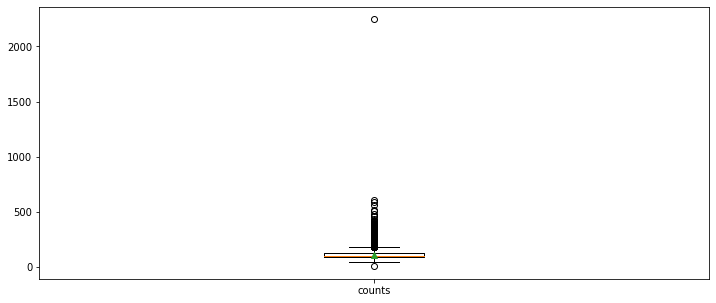

In [ ]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot([len_docs],
             labels=['counts'],
             showmeans=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7754faf050>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7754fafad0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7754faaa90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7754fb55d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7754fbf090>],
 'means': [<matplotlib.lines.Line2D at 0x7f7754fb5b10>]}

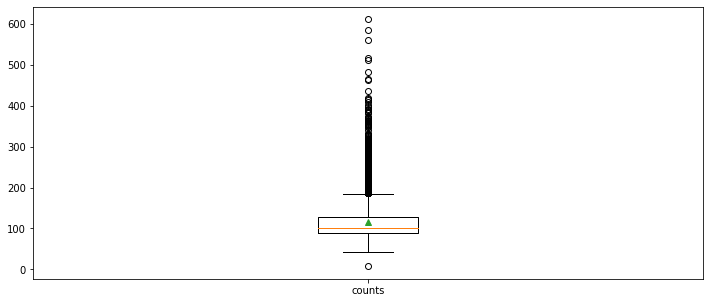

In [ ]:
filtered_len_docs = [l for l in len_docs if l < 2000]

plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot(filtered_len_docs,
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

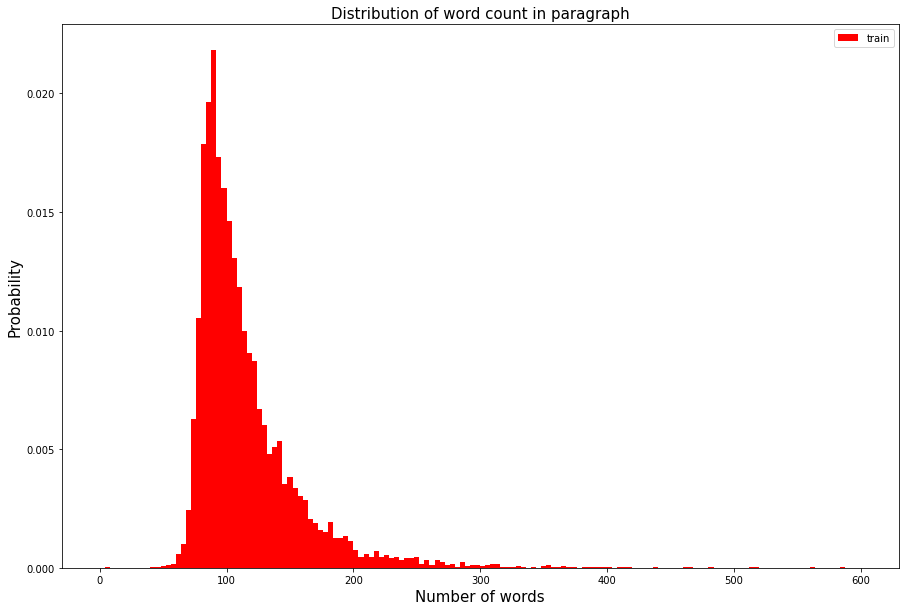

In [ ]:
plt.figure(figsize=(15, 10))
plt.hist(filtered_len_docs, bins=150, range=[0,600], facecolor='r', density=True, label='train')
plt.title("Distribution of word count in paragraph", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

```
지문 텍스트 버트 토크나이저 토큰 길이 분석
```

In [ ]:
len_bert_tokenized_docs = []
for d in documents:
    len_bert_tokenized_docs.append(len(bert_tokenizer.encode(d, add_special_tokens=False).tokens))

print('텍스트 최대 길이: {}'.format(np.max(len_bert_tokenized_docs)))
print('텍스트 최소 길이: {}'.format(np.min(len_bert_tokenized_docs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_bert_tokenized_docs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_bert_tokenized_docs)))
print('텍스트 중간 길이: {}'.format(np.median(len_bert_tokenized_docs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_docs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_docs, 75)))

텍스트 최대 길이: 6367
텍스트 최소 길이: 120
텍스트 평균 길이: 311.88
텍스트 길이 표준편차: 129.44
텍스트 중간 길이: 279.0
제 1 사분위 텍스트 길이: 239.0
제 3 사분위 텍스트 길이: 344.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f7754d7df10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7754db8d10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7754d95d90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7754d1b8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7754d848d0>],
 'means': [<matplotlib.lines.Line2D at 0x7f7754f5e050>]}

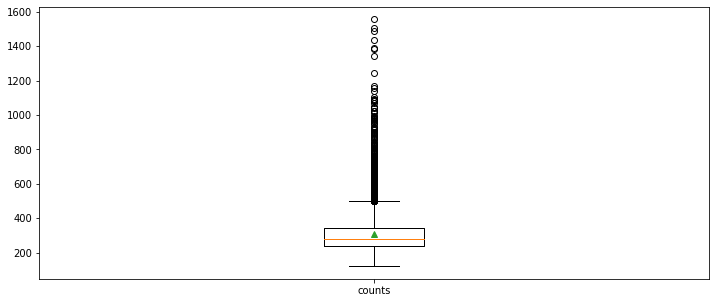

In [ ]:
filtered_len_bert_tokenized_docs = [l for l in len_bert_tokenized_docs if l < 3000]

plt.figure(figsize=(12, 5))

plt.boxplot(filtered_len_bert_tokenized_docs,
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

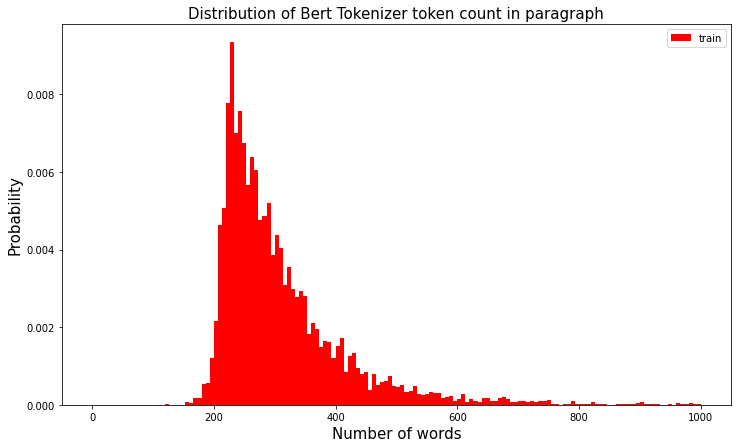

In [ ]:
plt.figure(figsize=(12, 7))
plt.hist(filtered_len_bert_tokenized_docs, bins=150, range=[0,1000], facecolor='r', density=True, label='train')
plt.title("Distribution of Bert Tokenizer token count in paragraph", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

- 지문 텍스트 어휘 빈도 분석

```
어절 토큰 기준
```

In [ ]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sentences = []
for d in documents:
    sentences += sent_tokenize(d)

print('전체 문장 수: {}'.format(len(sentences)))
sampled_docs = sample(sentences, 20000)

전체 문장 수: 67884


(-0.5, 799.5, 599.5, -0.5)

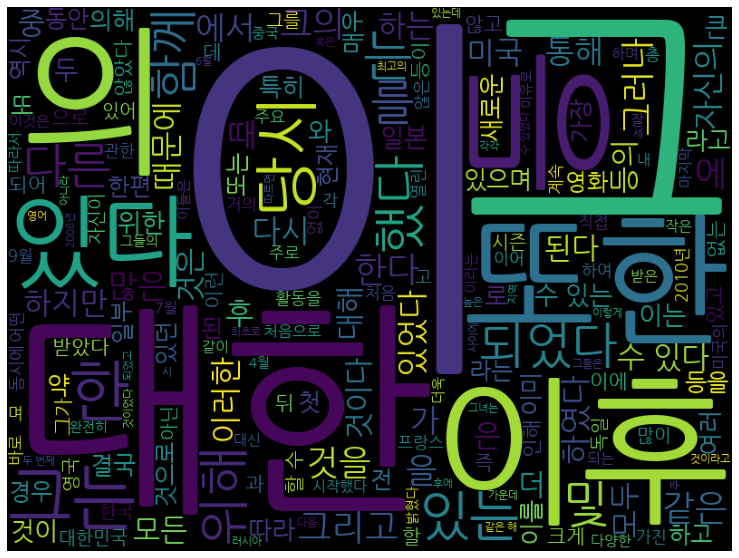

In [ ]:
font_path = os.path.join(DATA_PATH, 'NanumGothic.ttf')
cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(sampled_docs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

```
명사 토큰 기준
```

(-0.5, 799.5, 599.5, -0.5)

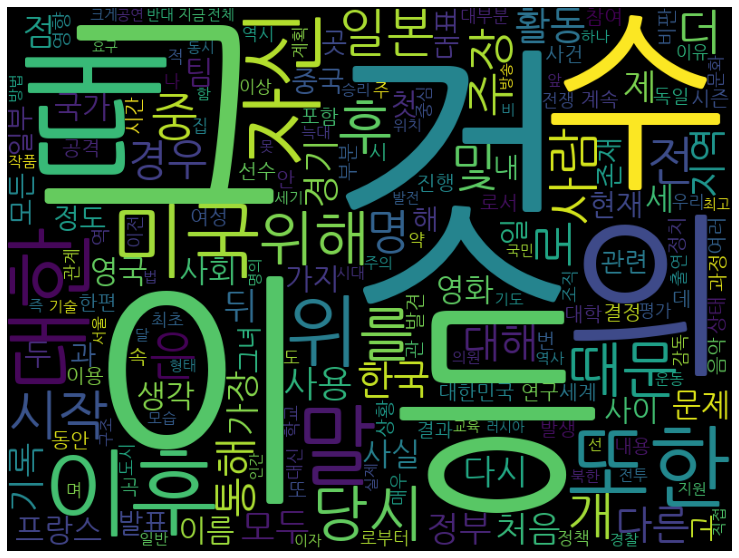

In [ ]:
noun_extracted_docs = []
for d in sampled_docs:
    noun_extracted_docs += phoneme_tokenizer.nouns(d)

cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(noun_extracted_docs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

- 질문 데이터 분석

In [ ]:
questions = []
for d in train_data['data']:
    qas = [p['qas'] for p in d['paragraphs']]
    for c in qas:
        questions += [q['question'] for q in c]

print('전체 질문 수: {}'.format(len(questions)))

전체 질문 수: 60407


```
질문 텍스트 어절 토큰 길이 분석
```

In [ ]:
len_qs = []
for q in questions:
    len_qs.append(len(q.split()))

print('텍스트 최대 길이: {}'.format(np.max(len_qs)))
print('텍스트 최소 길이: {}'.format(np.min(len_qs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_qs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_qs)))
print('텍스트 중간 길이: {}'.format(np.median(len_qs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_qs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_qs, 75)))

텍스트 최대 길이: 35
텍스트 최소 길이: 1
텍스트 평균 길이: 7.85
텍스트 길이 표준편차: 3.09
텍스트 중간 길이: 7.0
제 1 사분위 텍스트 길이: 6.0
제 3 사분위 텍스트 길이: 10.0


{'boxes': [<matplotlib.lines.Line2D at 0x7fa5aa9266d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7fa5aa8d9710>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa5adc5fc90>],
 'means': [<matplotlib.lines.Line2D at 0x7fa5adca9c50>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa5adc5f210>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fa57ba0ba50>,
  <matplotlib.lines.Line2D at 0x7fa5aa8d91d0>]}

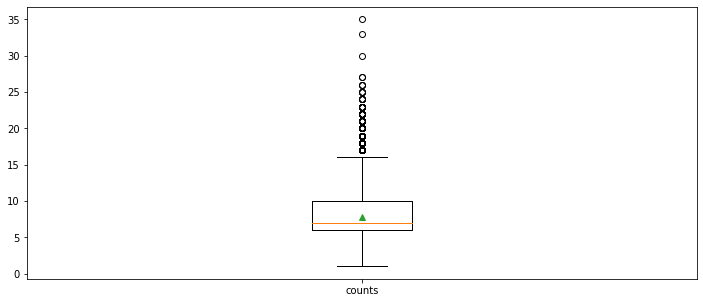

In [ ]:
plt.figure(figsize=(12, 5))

plt.boxplot([len_qs],
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

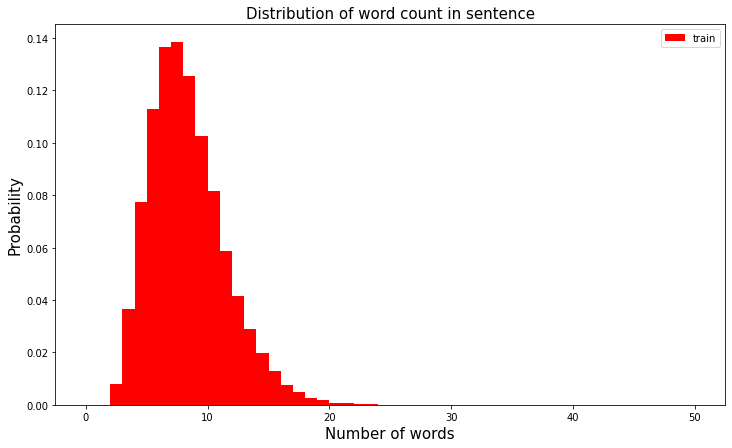

In [ ]:
plt.figure(figsize=(12, 7))
plt.hist(len_qs, bins=50, range=[0,50], facecolor='r', density=True, label='train')
plt.title("Distribution of word count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

```
질문 텍스트 버트 토크나이저 토큰 길이 분석
```

In [ ]:
len_bert_tokenized_q = []
for q in questions:
    len_bert_tokenized_q.append(len(bert_tokenizer.encode(q, add_special_tokens=False).tokens))

print('텍스트 최대 길이: {}'.format(np.max(len_bert_tokenized_q)))
print('텍스트 최소 길이: {}'.format(np.min(len_bert_tokenized_q)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_bert_tokenized_q)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_bert_tokenized_q)))
print('텍스트 중간 길이: {}'.format(np.median(len_bert_tokenized_q)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_q, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_q, 75)))

텍스트 최대 길이: 91
텍스트 최소 길이: 4
텍스트 평균 길이: 22.07
텍스트 길이 표준편차: 7.96
텍스트 중간 길이: 21.0
제 1 사분위 텍스트 길이: 16.0
제 3 사분위 텍스트 길이: 27.0


{'boxes': [<matplotlib.lines.Line2D at 0x7fa578889f10>],
 'caps': [<matplotlib.lines.Line2D at 0x7fa578892e90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa57881f550>],
 'means': [<matplotlib.lines.Line2D at 0x7fa57881afd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa57881aad0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fa578be7f10>,
  <matplotlib.lines.Line2D at 0x7fa578892a10>]}

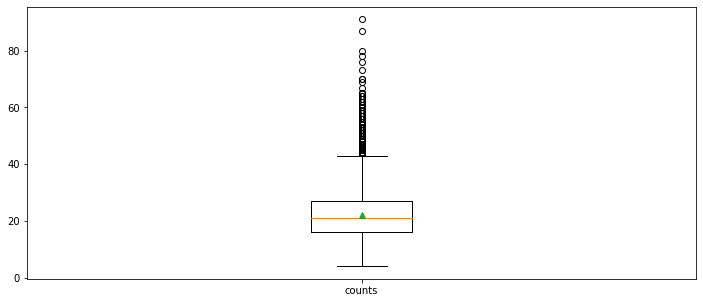

In [ ]:
plt.figure(figsize=(12, 5))

plt.boxplot([len_bert_tokenized_q],
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

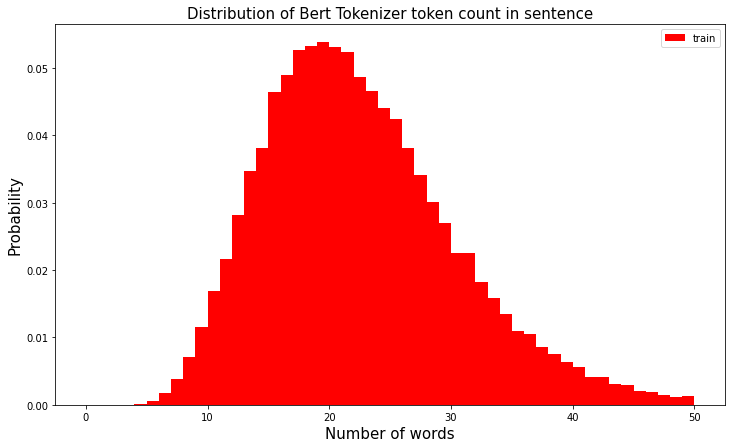

In [ ]:
plt.figure(figsize=(12, 7))
plt.hist(len_bert_tokenized_q, bins=50, range=[0,50], facecolor='r', density=True, label='train')
plt.title("Distribution of Bert Tokenizer token count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

- 질문 텍스트 어휘 빈도 분석

```
어절 토큰 기준
```

In [ ]:
sampled_questions = sample(questions, 20000)

(-0.5, 799.5, 599.5, -0.5)

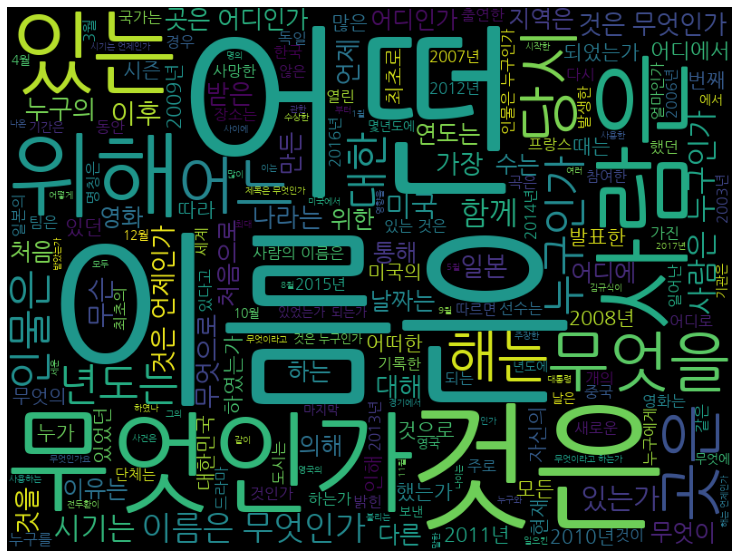

In [ ]:
cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(sampled_questions))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

```
명사 토큰 기준
```

(-0.5, 799.5, 599.5, -0.5)

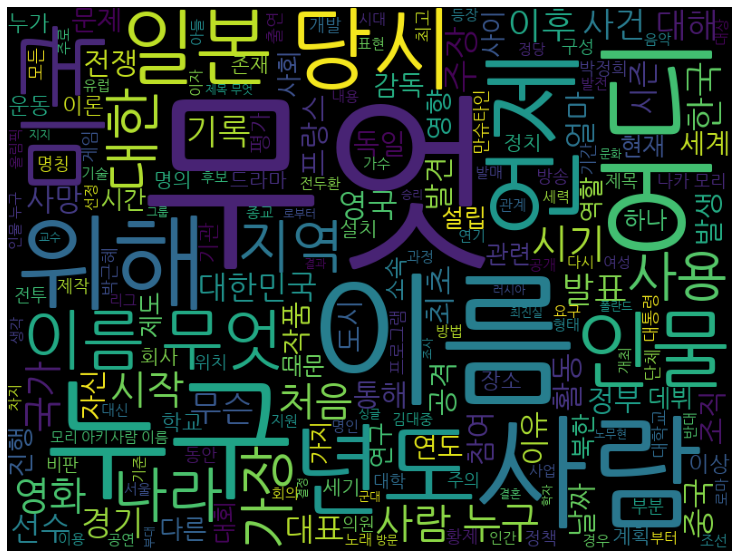

In [ ]:
noun_extracted_qs = []
for q in sampled_questions:
    noun_extracted_qs += phoneme_tokenizer.nouns(q)

cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(noun_extracted_qs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

#### 5.2 환경설정

In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=1c0a53725116bdc4ba67afbf094c12449295ed75854306d4a581e172c96c5537
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import urllib
import wget

MAX_LEN = 384
EPOCHS = 3
VERBOSE = 2
BATCH_SIZE = 16

In [ ]:
def plot_graphs(history, string, string_1, string_2):
    # loss
    plt.plot(history.history[string])
    plt.plot(history.history[string_1])
    plt.plot(history.history[string_2])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, string_1, string_2])
    plt.show()

In [ ]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

In [ ]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False)
save_path = "bert-base-multilingual-cased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert-base-multilingual-cased/vocab.txt", lowercase=False)

#### 5.3 데이터 전처리

In [ ]:
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

In [ ]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json', out='./bert-base-multilingual-cased/')

'./bert-base-multilingual-cased//bert-base-multilingual-cased-config.json'

In [ ]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-config.json', './bert-base-multilingual-cased/config.json')

In [ ]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-tf_model.h5', out='./bert-base-multilingual-cased/')

'./bert-base-multilingual-cased//bert-base-multilingual-cased-tf_model.h5'

In [ ]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-tf_model.h5', './bert-base-multilingual-cased/tf_model.h5')

In [ ]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = MAX_LEN - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets


def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                answer_text = qa["answers"][0]["text"]
                start_char_idx = qa["answers"][0]["answer_start"]
                squad_eg = SquadExample(
                    question, context, start_char_idx, answer_text
                )
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y


In [ ]:
with open(train_path) as f:
    raw_train_data = json.load(f)

with open(eval_path) as f:
    raw_eval_data = json.load(f)


train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

60407 training points created.
5774 evaluation points created.


#### 5.4 모델 학습

In [ ]:
class TFBERTQuestionAnswering(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBERTQuestionAnswering, self).__init__()

        self.encoder = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.start_logit = tf.keras.layers.Dense(num_class, name="start_logit", use_bias=False)
        self.end_logit = tf.keras.layers.Dense(num_class, name="end_logit", use_bias=False)
        self.flatten = tf.keras.layers.Flatten()
        self.softmax = tf.keras.layers.Activation(tf.keras.activations.softmax)

    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = inputs
        embedding = self.encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
        start_logits = self.start_logit(embedding)
        start_logits = self.flatten(start_logits)

        end_logits = self.end_logit(embedding)
        end_logits = self.flatten(end_logits)

        start_probs = self.softmax(start_logits)
        end_probs = self.softmax(end_logits)

        return start_probs, end_probs

In [ ]:
korquad_model = TFBERTQuestionAnswering(model_name='./bert-base-multilingual-cased/',dir_path='bert_ckpt', num_class=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

Some layers from the model checkpoint at ./bert-base-multilingual-cased/ were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ./bert-base-multilingual-cased/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def normalized_answer(s):
    def remove_(text):
        ''' 불필요한 기호 제거 '''
        text = re.sub("'", " ", text)
        text = re.sub('"', " ", text)
        text = re.sub('《', " ", text)
        text = re.sub('》', " ", text)
        text = re.sub('<', " ", text)
        text = re.sub('>', " ", text)
        text = re.sub('〈', " ", text)
        text = re.sub('〉', " ", text)
        text = re.sub("\(", " ", text)
        text = re.sub("\)", " ", text)
        text = re.sub("‘", " ", text)
        text = re.sub("’", " ", text)
        return text

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_punc(lower(remove_(s))))

In [ ]:
class ExactMatch(keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalized_answer(pred_ans)
            normalized_true_ans = normalized_answer(squad_eg.answer_text)
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")

In [ ]:
exact_match_callback = ExactMatch(x_eval, y_eval)

In [ ]:
korquad_model.compile(optimizer=optimizer, loss=[loss, loss])

In [ ]:
model_name = "tf2_bert_korquad"

checkpoint_path = os.path.join(DATA_PATH, 'bert_KorQuAD_weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

/gdrive/My Drive/Colab Notebooks/00_Lectures/NLP/data/bert -- Folder already exists 



In [ ]:
history = korquad_model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,  # For demonstration, 3 epochs are recommended
    verbose=VERBOSE,
    batch_size=16,
    callbacks=[exact_match_callback, cp_callback]
)

Epoch 1/3


In [ ]:
print(history.history)

{'loss': [1.6154567003250122, 1.0489535331726074, 0.8302596807479858], 'output_1_loss': [0.7417199611663818, 0.473328560590744, 0.3712247312068939], 'output_2_loss': [0.8737384080886841, 0.575624406337738, 0.45903465151786804]}


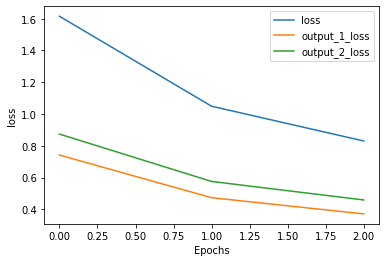

In [ ]:
plot_graphs(history, 'loss', 'output_1_loss', 'output_2_loss')